# 📈 Week 14: Recurrent Neural Networks (RNN, LSTM, GRU)

---

## 🎯 Learning Objectives

**By the end of this week, you will understand:**
1. Sequential data modeling concepts
2. RNN architecture and limitations
3. LSTM (Long Short-Term Memory) networks
4. GRU (Gated Recurrent Units)
5. Time series forecasting with recurrent models

---

## 📚 Why Sequence Models for Finance?

Financial data is inherently **sequential** - today's price depends on yesterday's, market sentiment evolves over time, and patterns emerge in sequences of trades.

**Key Applications:**
- Price prediction
- Volatility forecasting
- Order flow analysis
- Sentiment trajectory

---

---

## 📖 Section 1: Recurrent Neural Networks (RNN)

### 1.1 The Sequence Problem

Traditional neural networks treat each input independently. But in finance:
- Past returns influence future returns
- Volatility clusters over time
- Trends persist

**RNN Solution:** Feed output back as input, creating a "memory" of past states.

### 1.2 RNN Architecture

```
     ┌─────────────────────────────────────┐
     │              h(t-1)                  │
     └───────────────┬─────────────────────┘
                     │
                     ▼
     x(t) ───► [ RNN Cell ] ───► h(t) ───► y(t)
                     │
                     ▼
               x(t+1) ───► [ RNN Cell ] ───► ...
```

**Mathematical Formulation:**

$$h_t = \tanh(W_{hh} h_{t-1} + W_{xh} x_t + b_h)$$

$$y_t = W_{hy} h_t + b_y$$

Where:
- $h_t$ = hidden state at time $t$
- $x_t$ = input at time $t$
- $W_{hh}, W_{xh}, W_{hy}$ = weight matrices
- $b_h, b_y$ = bias vectors

### 1.3 Vanishing Gradient Problem

Standard RNNs struggle with long sequences because gradients either:
- **Vanish:** Become too small to learn (can't remember distant past)
- **Explode:** Become too large (unstable training)

This limits RNNs to ~10-20 timestep dependencies.

---

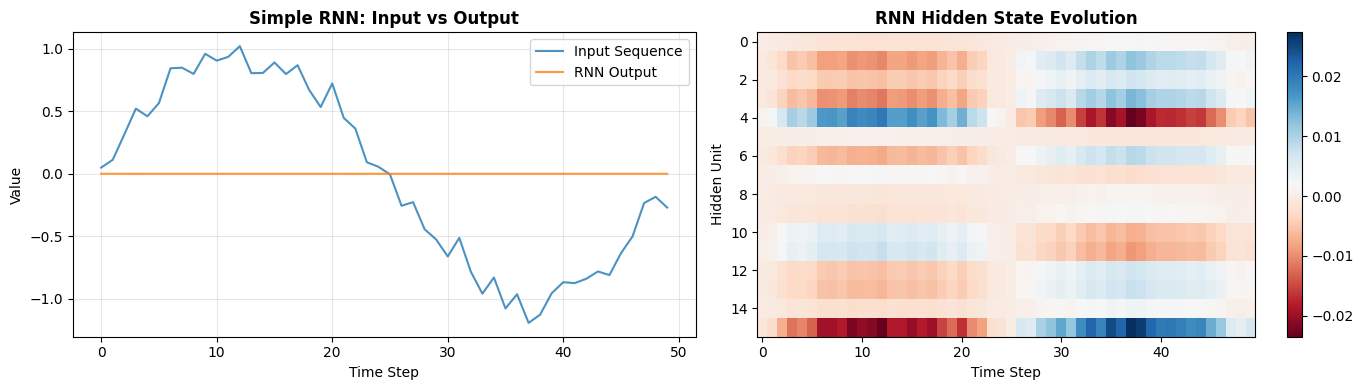

✅ Basic RNN demonstrated - note the chaotic hidden states


In [1]:
# ============================================================
# BASIC RNN DEMONSTRATION
# ============================================================
import numpy as np
import matplotlib.pyplot as plt

# Create sample sequence data
np.random.seed(42)
t = np.linspace(0, 8*np.pi, 200)
sequence = np.sin(t) + 0.1 * np.random.randn(len(t))

# Simple RNN implementation
class SimpleRNN:
    def __init__(self, hidden_size=32, input_size=1):
        self.hidden_size = hidden_size
        scale = 0.01
        self.W_hh = np.random.randn(hidden_size, hidden_size) * scale
        self.W_xh = np.random.randn(hidden_size, input_size) * scale
        self.W_hy = np.random.randn(1, hidden_size) * scale
        self.b_h = np.zeros((hidden_size, 1))
        self.b_y = np.zeros((1, 1))
    
    def forward(self, inputs):
        h = np.zeros((self.hidden_size, 1))
        outputs = []
        hiddens = [h.copy()]
        
        for x in inputs:
            x = np.array([[x]])
            h = np.tanh(self.W_hh @ h + self.W_xh @ x + self.b_h)
            y = self.W_hy @ h + self.b_y
            outputs.append(y[0, 0])
            hiddens.append(h.copy())
        
        return outputs, hiddens

# Run RNN
rnn = SimpleRNN(hidden_size=16)
outputs, hiddens = rnn.forward(sequence[:50])

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

ax1 = axes[0]
ax1.plot(sequence[:50], label='Input Sequence', alpha=0.8)
ax1.plot(outputs, label='RNN Output', alpha=0.8)
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Value')
ax1.set_title('Simple RNN: Input vs Output', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
h_matrix = np.array([h.flatten() for h in hiddens[1:]])
im = ax2.imshow(h_matrix.T, aspect='auto', cmap='RdBu')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Hidden Unit')
ax2.set_title('RNN Hidden State Evolution', fontweight='bold')
plt.colorbar(im, ax=ax2)

plt.tight_layout()
plt.show()

print("✅ Basic RNN demonstrated - note the chaotic hidden states")

---

## 📖 Section 2: Long Short-Term Memory (LSTM)

### 2.1 LSTM Architecture

LSTM solves the vanishing gradient problem with **gates** that control information flow.

```
                    Cell State (C)
     ─────────────────────────────────────────►
                │         │         │
            ┌───┴───┐ ┌───┴───┐ ┌───┴───┐
            │ Forget │ │ Input │ │ Output│
            │  Gate  │ │  Gate │ │  Gate │
            └───┬───┘ └───┬───┘ └───┬───┘
                │         │         │
     ──────────────────────────────────────────►
              Hidden State (h)
```

### 2.2 LSTM Equations

**Forget Gate:** What to discard from cell state
$$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$

**Input Gate:** What new information to store
$$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$$
$$\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$$

**Cell State Update:**
$$C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t$$

**Output Gate:** What to output
$$o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$$
$$h_t = o_t \odot \tanh(C_t)$$

Where $\sigma$ is sigmoid and $\odot$ is element-wise multiplication.

### 2.3 Why LSTM Works

- **Cell state acts as a "conveyor belt"** - information flows easily
- **Forget gate** learns what's irrelevant
- **Input gate** learns what's important to remember
- **Output gate** learns what to expose

This allows LSTMs to capture dependencies over 100+ timesteps!

---

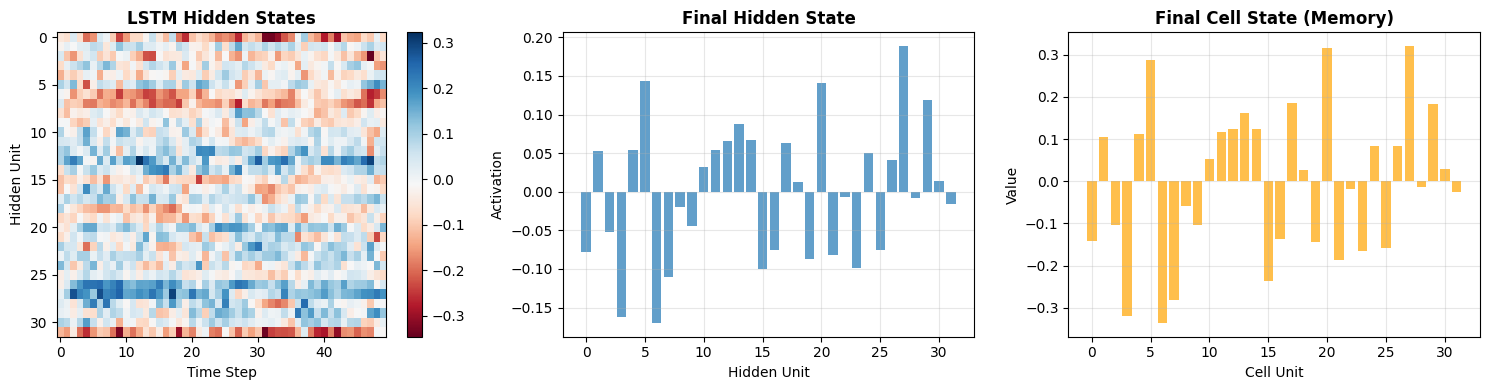

✅ LSTM maintains stable hidden and cell states


In [2]:
# ============================================================
# LSTM GATE VISUALIZATION
# ============================================================
import torch
import torch.nn as nn

# Create sample data
torch.manual_seed(42)
seq_len = 50
x = torch.randn(seq_len, 1, 10)  # (seq_len, batch, features)

# LSTM cell to inspect gates
lstm = nn.LSTM(10, 32, batch_first=False)

# Run through LSTM
h0 = torch.zeros(1, 1, 32)
c0 = torch.zeros(1, 1, 32)
output, (hn, cn) = lstm(x, (h0, c0))

# Visualize output
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Hidden states over time
ax1 = axes[0]
h_seq = output.squeeze().detach().numpy()
im1 = ax1.imshow(h_seq.T, aspect='auto', cmap='RdBu')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Hidden Unit')
ax1.set_title('LSTM Hidden States', fontweight='bold')
plt.colorbar(im1, ax=ax1)

# Final hidden state
ax2 = axes[1]
final_h = hn.squeeze().detach().numpy()
ax2.bar(range(len(final_h)), final_h, alpha=0.7)
ax2.set_xlabel('Hidden Unit')
ax2.set_ylabel('Activation')
ax2.set_title('Final Hidden State', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Final cell state
ax3 = axes[2]
final_c = cn.squeeze().detach().numpy()
ax3.bar(range(len(final_c)), final_c, alpha=0.7, color='orange')
ax3.set_xlabel('Cell Unit')
ax3.set_ylabel('Value')
ax3.set_title('Final Cell State (Memory)', fontweight='bold')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ LSTM maintains stable hidden and cell states")

---

## 📖 Section 3: Gated Recurrent Unit (GRU)

### 3.1 GRU Simplification

GRU is a **simplified LSTM** with only 2 gates (vs 3), making it faster to train with similar performance.

```
     ┌─────────────────────────────────────┐
     │           h(t-1)                     │
     └─────────┬───────────────────────────┘
               │
     ┌─────────┼─────────┐
     │    ┌────┴────┐    │
     │    │ Reset   │    │
     │    │  Gate   │    │
     │    └────┬────┘    │
     │         │         │
     │    ┌────┴────┐    │
     │    │ Update  │    │
     │    │  Gate   │    │
     │    └────┬────┘    │
     └─────────┼─────────┘
               │
     ──────────┴─────────► h(t)
```

### 3.2 GRU Equations

**Reset Gate:** How much past to forget
$$r_t = \sigma(W_r \cdot [h_{t-1}, x_t] + b_r)$$

**Update Gate:** How much new vs old
$$z_t = \sigma(W_z \cdot [h_{t-1}, x_t] + b_z)$$

**Candidate Hidden State:**
$$\tilde{h}_t = \tanh(W_h \cdot [r_t \odot h_{t-1}, x_t] + b_h)$$

**Final Hidden State:**
$$h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t$$

### 3.3 LSTM vs GRU

| Aspect | LSTM | GRU |
|--------|------|-----|
| Gates | 3 (forget, input, output) | 2 (reset, update) |
| Parameters | More | ~25% fewer |
| Training Speed | Slower | Faster |
| Long Dependencies | Excellent | Good |
| Best For | Complex sequences | Simpler sequences |

---

In [3]:
# ============================================================
# LSTM VS GRU COMPARISON
# ============================================================

# Create sample financial-like sequence
np.random.seed(42)
n = 500
trend = np.cumsum(np.random.randn(n) * 0.01)
seasonal = 0.05 * np.sin(np.linspace(0, 8*np.pi, n))
noise = np.random.randn(n) * 0.02
price = 100 * np.exp(trend + seasonal + noise)

# Normalize
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
price_scaled = scaler.fit_transform(price.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_len=30):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

X, y = create_sequences(price_scaled, seq_len=30)
X_train, y_train = X[:400], y[:400]
X_test, y_test = X[400:], y[400:]

# Convert to tensors
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train)
X_test_t = torch.FloatTensor(X_test)
y_test_t = torch.FloatTensor(y_test)

print(f"Training sequences: {len(X_train)}")
print(f"Test sequences: {len(X_test)}")
print(f"Sequence length: 30 days")

Training sequences: 400
Test sequences: 70
Sequence length: 30 days


In [4]:
# ============================================================
# DEFINE LSTM AND GRU MODELS
# ============================================================

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

lstm = LSTMModel()
gru = GRUModel()

print(f"LSTM parameters: {count_parameters(lstm):,}")
print(f"GRU parameters:  {count_parameters(gru):,}")
print(f"GRU is ~{100*(1 - count_parameters(gru)/count_parameters(lstm)):.1f}% smaller")

LSTM parameters: 50,497
GRU parameters:  37,889
GRU is ~25.0% smaller


In [5]:
# ============================================================
# TRAIN BOTH MODELS
# ============================================================
import time

def train_model(model, X_train, y_train, X_test, y_test, epochs=100, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    test_losses = []
    
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        model.eval()
        with torch.no_grad():
            test_output = model(X_test)
            test_loss = criterion(test_output, y_test)
            test_losses.append(test_loss.item())
    
    training_time = time.time() - start_time
    
    return train_losses, test_losses, training_time

# Train LSTM
torch.manual_seed(42)
lstm = LSTMModel()
lstm_train, lstm_test, lstm_time = train_model(lstm, X_train_t, y_train_t, X_test_t, y_test_t)

# Train GRU
torch.manual_seed(42)
gru = GRUModel()
gru_train, gru_test, gru_time = train_model(gru, X_train_t, y_train_t, X_test_t, y_test_t)

print(f"\n{'Model':<10} {'Train Loss':>12} {'Test Loss':>12} {'Time (s)':>10}")
print("-" * 50)
print(f"{'LSTM':<10} {lstm_train[-1]:>12.6f} {lstm_test[-1]:>12.6f} {lstm_time:>10.2f}")
print(f"{'GRU':<10} {gru_train[-1]:>12.6f} {gru_test[-1]:>12.6f} {gru_time:>10.2f}")


Model        Train Loss    Test Loss   Time (s)
--------------------------------------------------
LSTM           0.005632     0.014601       4.82
GRU            0.004117     0.006666       3.78


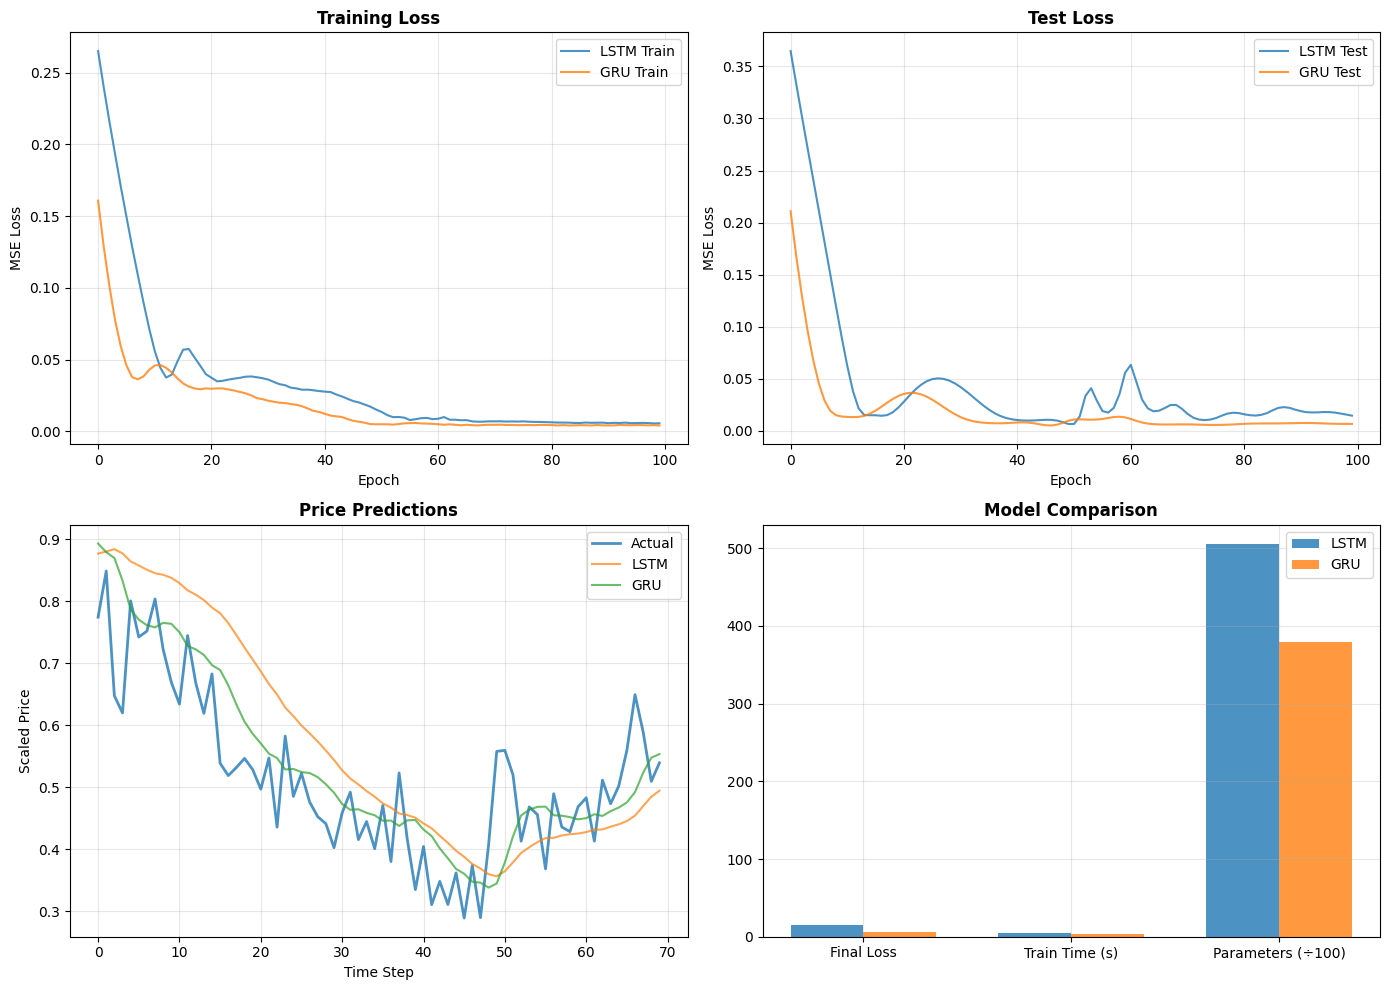

In [6]:
# ============================================================
# COMPARISON VISUALIZATION
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Training curves
ax1 = axes[0, 0]
ax1.plot(lstm_train, label='LSTM Train', alpha=0.8)
ax1.plot(gru_train, label='GRU Train', alpha=0.8)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE Loss')
ax1.set_title('Training Loss', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Test curves
ax2 = axes[0, 1]
ax2.plot(lstm_test, label='LSTM Test', alpha=0.8)
ax2.plot(gru_test, label='GRU Test', alpha=0.8)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MSE Loss')
ax2.set_title('Test Loss', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Predictions
ax3 = axes[1, 0]
lstm.eval()
gru.eval()
with torch.no_grad():
    lstm_pred = lstm(X_test_t).numpy()
    gru_pred = gru(X_test_t).numpy()

ax3.plot(y_test, label='Actual', linewidth=2, alpha=0.8)
ax3.plot(lstm_pred, label='LSTM', alpha=0.7)
ax3.plot(gru_pred, label='GRU', alpha=0.7)
ax3.set_xlabel('Time Step')
ax3.set_ylabel('Scaled Price')
ax3.set_title('Price Predictions', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Model comparison
ax4 = axes[1, 1]
metrics = ['Final Loss', 'Train Time (s)', 'Parameters (÷100)']
lstm_vals = [lstm_test[-1] * 1000, lstm_time, count_parameters(lstm)/100]
gru_vals = [gru_test[-1] * 1000, gru_time, count_parameters(gru)/100]

x = np.arange(len(metrics))
width = 0.35
ax4.bar(x - width/2, lstm_vals, width, label='LSTM', alpha=0.8)
ax4.bar(x + width/2, gru_vals, width, label='GRU', alpha=0.8)
ax4.set_xticks(x)
ax4.set_xticklabels(metrics)
ax4.set_title('Model Comparison', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 📖 Section 4: Practical Implementation Tips

### 4.1 Input Preparation

```python
# Shape: (batch_size, sequence_length, features)
# Example: 32 sequences, 60 days, 5 features
X.shape = (32, 60, 5)
```

### 4.2 Common Architectures for Finance

**Simple:**
```python
LSTM(64) → Dense(1)
```

**Stacked:**
```python
LSTM(64, return_sequences=True) → LSTM(32) → Dense(1)
```

**Bidirectional:**
```python
Bidirectional(LSTM(64)) → Dense(1)
```

### 4.3 Best Practices

| Practice | Why |
|----------|-----|
| Normalize inputs | Faster convergence |
| Use dropout | Prevent overfitting |
| Stateful batching | Maintain state across batches |
| Teacher forcing | Stabilize training |
| Gradient clipping | Prevent explosions |

### 4.4 Sequence Length Guidelines

| Task | Typical Length |
|------|---------------|
| Intraday prediction | 30-60 bars |
| Daily prediction | 20-60 days |
| Volatility forecasting | 60-252 days |
| Trend detection | 120+ days |

---

In [7]:
# ============================================================
# BEST PRACTICES DEMONSTRATION
# ============================================================

class EnhancedLSTM(nn.Module):
    """Production-ready LSTM with best practices."""
    
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.3):
        super(EnhancedLSTM, self).__init__()
        
        # Input normalization
        self.layer_norm = nn.LayerNorm(input_size)
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            batch_first=True, dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        # Attention mechanism (simple)
        self.attention = nn.Linear(hidden_size * 2, 1)
        
        # Output layers
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # Normalize input
        x = self.layer_norm(x)
        
        # LSTM
        lstm_out, _ = self.lstm(x)  # (batch, seq, hidden*2)
        
        # Attention weights
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)  # (batch, hidden*2)
        
        # Output
        out = torch.relu(self.fc1(context))
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

# Compare
enhanced = EnhancedLSTM()
print(f"Enhanced LSTM parameters: {count_parameters(enhanced):,}")

# Quick test
torch.manual_seed(42)
test_input = torch.randn(8, 30, 1)  # 8 samples, 30 days, 1 feature
output = enhanced(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {output.shape}")
print("✅ Enhanced LSTM with attention working")

Enhanced LSTM parameters: 142,084
Input shape: torch.Size([8, 30, 1])
Output shape: torch.Size([8, 1])
✅ Enhanced LSTM with attention working


---

## 📚 Section 5: Key Takeaways

### What You Learned:

1. **RNNs** process sequential data but suffer from vanishing gradients
2. **LSTMs** use forget/input/output gates to maintain long-term memory
3. **GRUs** are simpler (2 gates) and often equally effective
4. **Sequence length** depends on the trading horizon
5. **Bidirectional** models capture past and future context

### When to Use What:

| Model | Best For |
|-------|----------|
| Simple RNN | Very short sequences (<10 steps) |
| LSTM | Long dependencies, complex patterns |
| GRU | Medium sequences, faster training |
| Bidirectional | When full sequence is available |
| Attention | Variable importance across time |

### Financial Applications:

- **Price Prediction:** LSTM/GRU with 20-60 day windows
- **Volatility Forecasting:** LSTM with longer windows
- **Order Flow:** GRU for fast inference
- **Sentiment Sequences:** Bidirectional LSTM

---

## 📖 References

1. Hochreiter & Schmidhuber (1997) - "Long Short-Term Memory"
2. Cho et al. (2014) - "Learning Phrase Representations using RNN"
3. Fischer & Krauss (2018) - "Deep learning with LSTM for stock prediction"

---